In [1]:
# Load libraries
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# 載入資料

In [5]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 1, 27)

#stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = pd.read_csv('stack.csv',header=[0, 1])
#stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred',start,end)
idx_data = web.DataReader(idx_tickers, 'fred',start,end)

# 轉換資料

In [6]:
return_period = 5

# 取MSFT收盤價及日期
YA = stk_data.loc[
    :, [("Adj Close", "MSFT"), ("Unnamed: 0_level_0", "Unnamed: 0_level_1")]
]

# np.log取自然數log降低極值影響(常態分佈)
# diff(5)每筆收盤減前5天資料，計算周獲利(周一買入，週五賣出)
# shift(-5)向上，做訓練答案(未來狀態)
YC = np.log(YA["Adj Close", "MSFT"]).diff(return_period).shift(-return_period)

# 結合日期資料
YD = YA["Unnamed: 0_level_0", "Unnamed: 0_level_1"]
Y = pd.concat([YD, YC], axis=1)

# 訓練答案欄位名MSFT_pred
Y.columns = ["DATE", "MSFT_pred"]

# 取GOOGL, IBM收盤價及日期
X1A = stk_data.loc[
    :,
    [
        ("Adj Close", "GOOGL"),
        ("Adj Close", "IBM"),
        ("Unnamed: 0_level_0", "Unnamed: 0_level_1"),
    ],
]
X1A.columns = ["GOOGL", "IBM", "DATE"]

# np.log與diff(5)用法與剛剛Y相同，但不需要shift(-5)，因為是訓練資料(目前狀態)
X1C = np.log(X1A[["GOOGL", "IBM"]]).diff(return_period)

# 結合日期資料
X1D = X1A["DATE"]
X1 = pd.concat([X1D, X1C], axis=1)

# ccy_tickers與idx_tickers也以當日收盤減前五天收盤計算周獲利
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

# 用pd.concat橫向(axis=1)結合3周獲利、6周獲利、12周獲利當作輸入參數，並去空值
X4 = pd.concat(
    [
        np.log(stk_data.loc[:, ("Adj Close", "MSFT")]).diff(i)
        for i in [
            return_period,
            return_period * 3,
            return_period * 6,
            return_period * 12,
        ]
    ],
    axis=1,
).dropna()

# 結合日期資料
X4 = pd.concat([X1D, X4], axis=1)

# 欄位名 DATE,MSFT_DT, MSFT_3DT,MSFT_6DT,MSFT_12DT
X4.columns = ["DATE", "MSFT_DT", "MSFT_3DT", "MSFT_6DT", "MSFT_12DT"]

# 結合X1~X4訓練資料(row data)
X2 = X2.reset_index()
X2["DATE"] = X2["DATE"].astype(str)
X3 = X3.reset_index()
X3["DATE"] = X3["DATE"].astype(str)
dfs = [X1, X2, X3, X4]
X = X1
for df in dfs[1:]:
    X = X.merge(df, how="left", on=["DATE"])


# iloc[::return_period, :]:每5筆取一筆，全部欄位，並去空值
dataset = (
    Y[0:14000]
    .merge(X, how="left", on=["DATE"])
    .dropna()
    .iloc[::return_period, :]
    .set_index("DATE")
)

# 訓練答案
Y = dataset.loc[:, "MSFT_pred"]

# 訓練資料
X = dataset.loc[:, X.columns[1:]]


# 探索性資料分析

## 敘述性統計

In [7]:
# dataset樣貌

dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,0.004274,0.003365,-0.000495,-0.000030,-0.001255,0.001236,0.001260,0.001485,0.004164,0.012840,0.024010,0.050196
std,0.032070,0.032207,0.024233,0.013911,0.013611,0.016289,0.015845,0.164040,0.031997,0.046606,0.060931,0.076167
min,-0.155140,-0.107924,-0.116191,-0.046548,-0.083192,-0.050600,-0.053693,-0.500200,-0.129982,-0.133804,-0.127909,-0.136877
25%,-0.010809,-0.014996,-0.013539,-0.007622,-0.006964,-0.005665,-0.007030,-0.100651,-0.012328,-0.016181,-0.010785,0.005933
50%,0.002948,0.001603,0.001430,0.000599,-0.000703,0.001129,0.001929,0.000370,0.002948,0.012923,0.023756,0.059698
75%,0.018319,0.020395,0.014286,0.008210,0.006693,0.011612,0.010279,0.077737,0.018492,0.036770,0.056501,0.101026
max,0.139908,0.114421,0.068629,0.048388,0.034437,0.054438,0.047763,0.483642,0.139908,0.172385,0.215133,0.266182


In [8]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
DATE,,,,,,,,,,,,
2014-01-03,-0.023853,-0.011213,0.006936,-0.005632,-0.004071,-0.005462,-0.000511,0.099242,-0.014257,-0.018787,0.004616,0.119227
2014-01-13,0.033454,0.005053,-0.009942,-0.010304,-0.002013,-0.004153,-0.010229,-0.020127,-0.032347,-0.035663,-0.072227,0.017323
2014-01-21,0.002761,0.035619,0.022922,0.003270,0.001154,0.002672,0.002475,0.046927,0.033454,-0.030496,-0.049356,0.076509
2014-01-29,-0.023180,-0.051157,-0.032626,-0.020915,-0.000604,-0.039054,-0.039526,0.301027,0.020114,0.006843,-0.000818,0.042247
2014-02-05,0.045034,0.032250,-0.012320,-0.008056,-0.015395,-0.012797,-0.019152,0.139637,-0.023180,0.001117,-0.026992,-0.038279


## 直方圖

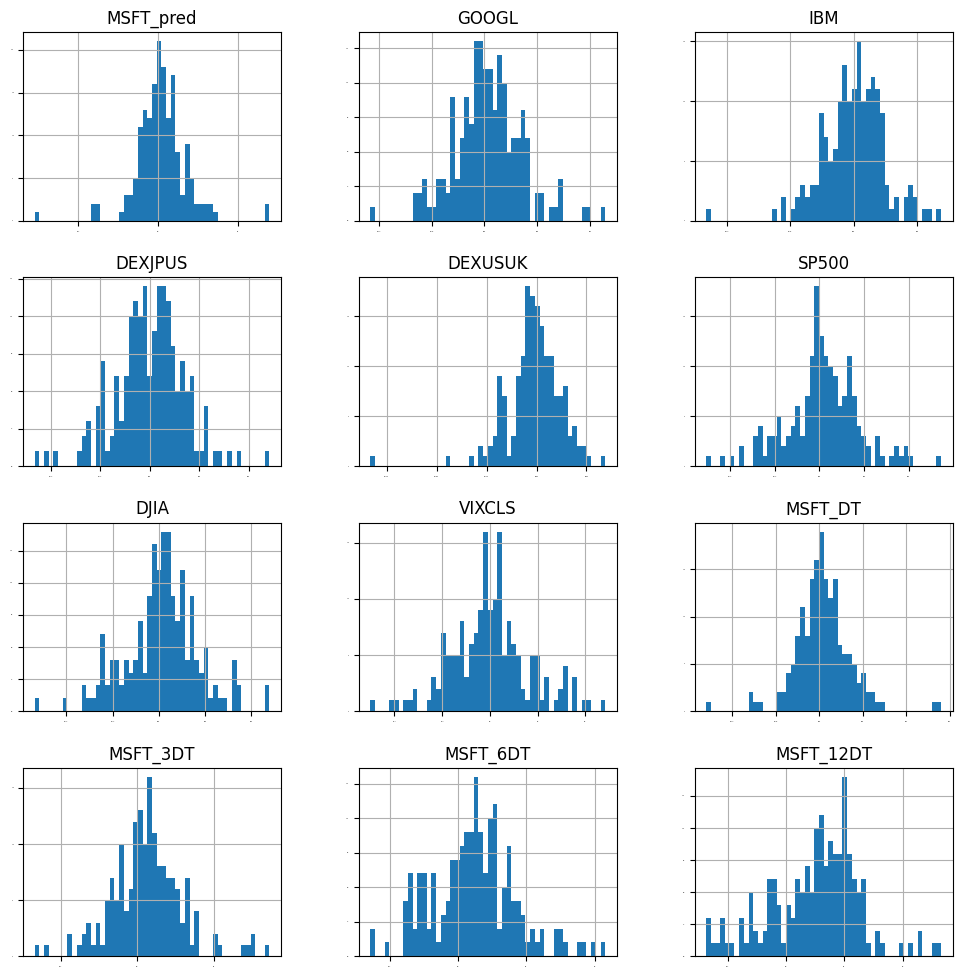

In [9]:
# 查看各欄位直方圖

# bins:長條圖數(資料分組數) 、 sharex/sharex:共享x軸/y軸 、 figsize:圖形長寬
dataset.hist(
    bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12)
)
pyplot.show()

直方圖顯示每個series的分布是獨立的

## 機率密度圖

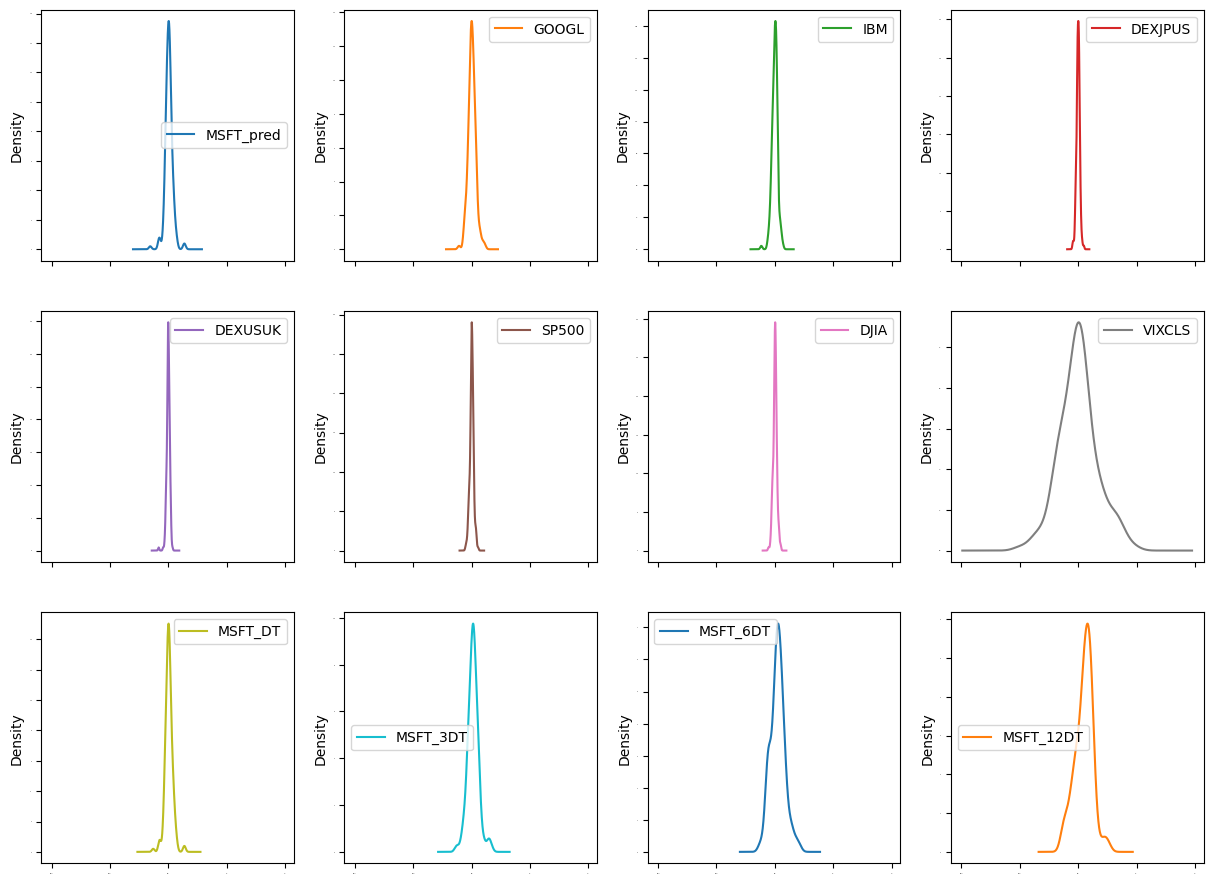

In [10]:
# 查看各欄位機率密度

# kind圖形種類(density機路密度縣) 、 subplots:子圖 、 layout:子圖行列分布 、 sharex共享x軸 、 legend:子圖圖示 、 fontsize:刻度字體大小 、 figsize:圖片大小
dataset.plot(
    kind="density",
    subplots=True,
    layout=(4, 4),
    sharex=True,
    legend=True,
    fontsize=1,
    figsize=(15, 15),
)
pyplot.show()

圖片顯示VIXCLS的變異數相對比其他欄位大

## 熱力圖

<AxesSubplot:title={'center':'Correlation Matrix'}>

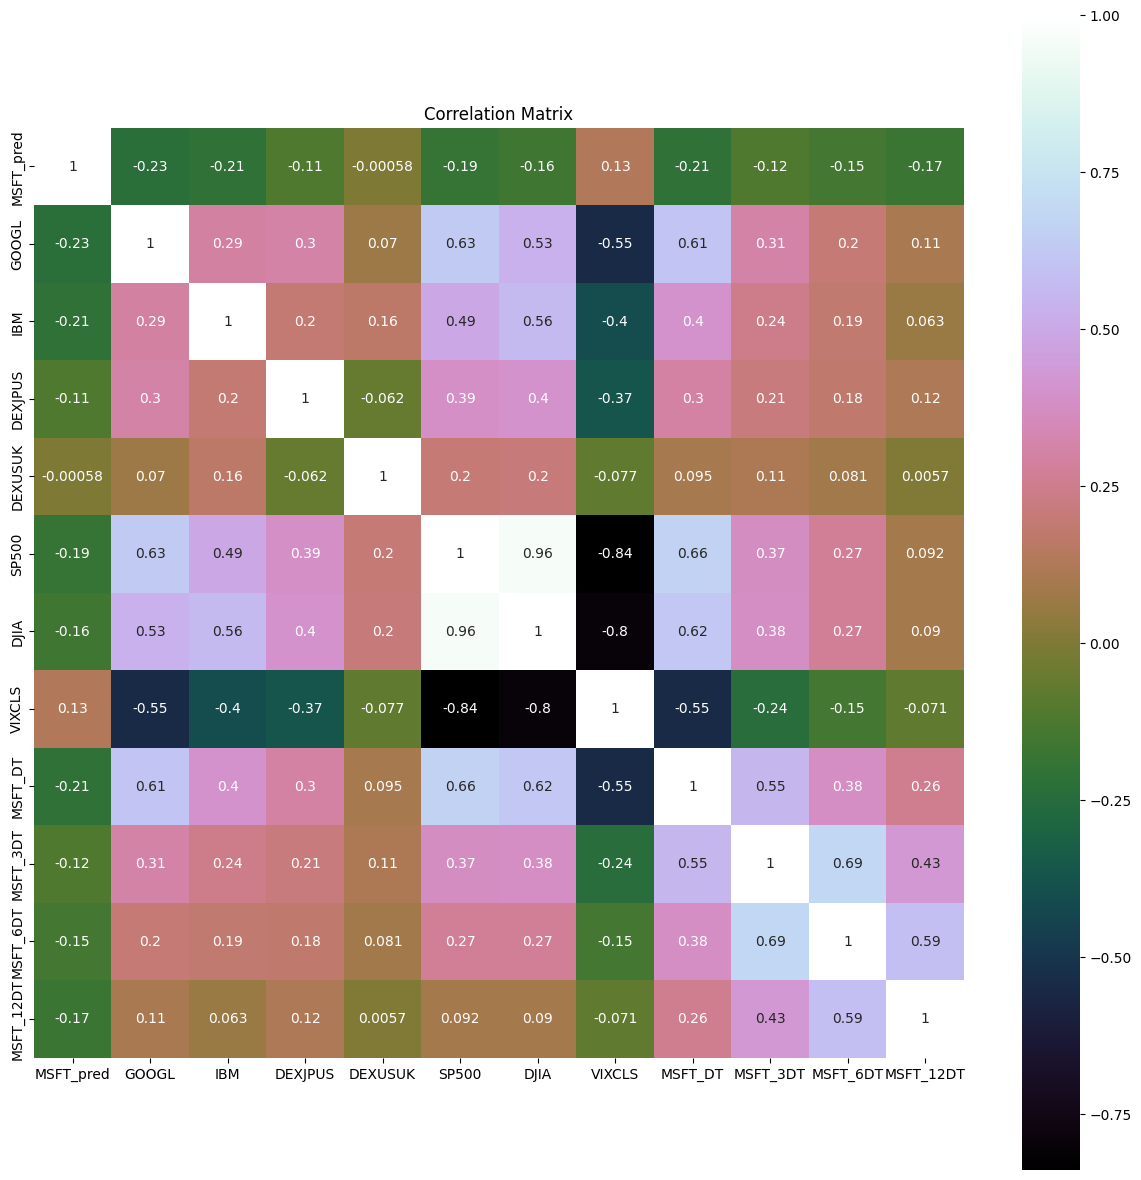

In [11]:
# 查看欄位間相關係數

# 計算欄位間相關係數
correlation = dataset.corr()

# 畫布(長寬)
pyplot.figure(figsize=(15, 15))

# 畫布標題
pyplot.title("Correlation Matrix")

# 畫熱力圖
# vmax:圖內數值最大值 、 square:對角相等 、 annot:每格數據顯示 、 cmap:熱力圖顏色
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="cubehelix")

5日、15日、30日、60日獲利之間存在先許相關性?;許多資產與VIXCLS存在負相關

## 散點圖

<Figure size 1500x1500 with 0 Axes>

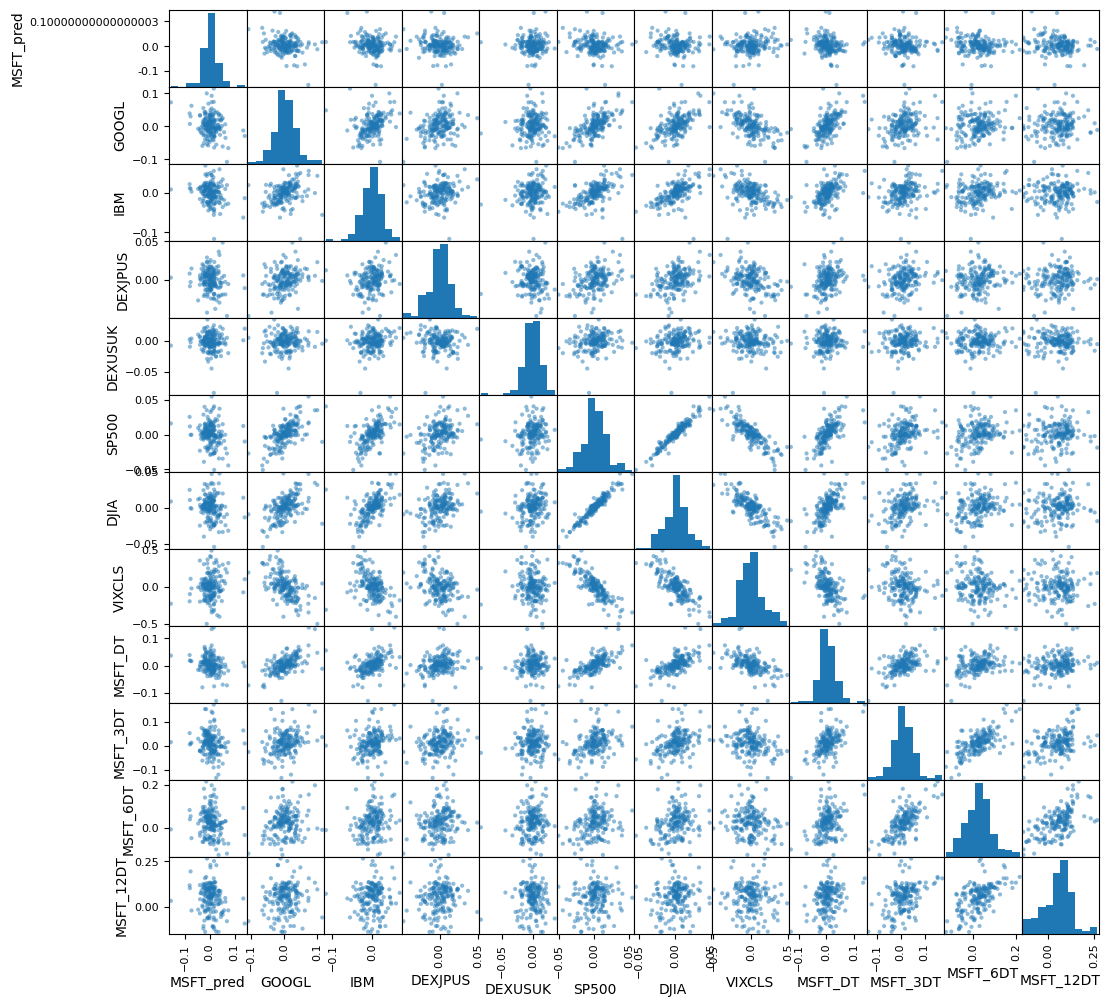

In [12]:
# 查看散點圖

# 畫布(長寬)
pyplot.figure(figsize=(15, 15))

# 散佈矩陣(資料、長寬)
scatter_matrix(dataset, figsize=(12, 12))
pyplot.show()

5日、15日、30日、60日獲利之間存一些線性關係

## 時間序列

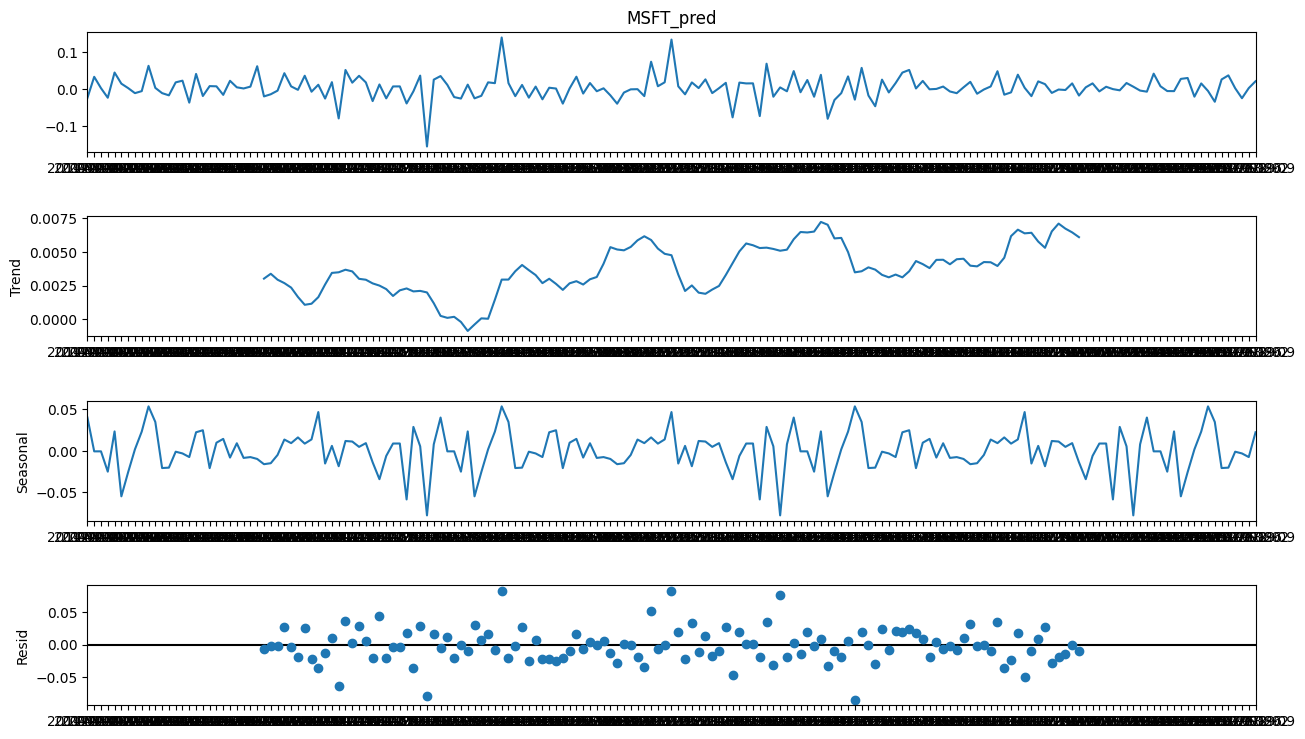

In [13]:
#查看時間序列

#時間序列圖
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

獲利趨勢呈現先下降再上升，模型中可能表現常數/偏差項;殘差相對小

# 特徵選擇

In [14]:
#特徵選擇

#f_regression回歸函數
bestfeatures = SelectKBest(k=5,score_func=f_regression)
fit = bestfeatures.fit(X,Y)

#特徵分數
dfscores = pd.DataFrame(fit.scores_)

#結合特徵欄位
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#df欄位名
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

#排序前10
featureScores=featureScores.nlargest(10,'Score').set_index('Specs')
featureScores

,Score
Specs,
GOOGL,9.491426
MSFT_DT,8.158895
IBM,7.935245
SP500,6.131844
MSFT_12DT,5.212162
DJIA,4.354490
MSFT_6DT,3.701915
VIXCLS,2.870771
MSFT_3DT,2.334981


# 拆分訓練/測試資料

In [15]:
#拆分訓練/測試資料

#測試資料比例
validation_size = 0.2

#訓練資料筆數
train_size = int(len(X) * (1-validation_size))

#因牽涉時序問題，訓練資料及測試資料須有序拆分
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

# 交叉驗證

In [16]:
#使用10-fold交叉驗證

num_folds = 10
seed = 7

#考慮某些模型及交叉驗證過程中的隨機性，使用均方誤差指標評估演算法
scoring ='neg_mean_squared_error'

## 載入模型

In [17]:
#回歸模型

#模型列表
models = []

#線性回歸
models.append(('LR', LinearRegression()))

#Lasso L1 norm:迴歸模型(可調整「誤差項」與「解釋變數量」)
models.append(('LASSO', Lasso()))

#彈性網路 L1 norm與L2 norm綜合版，有效正規化優勢以及Lasso懲罰項能夠進行變數挑選優勢
models.append(('EN', ElasticNet()))

#k-nearest neighbors預測值為k個最近鄰居的值的平均值
models.append(('KNN', KNeighborsRegressor()))

#決策樹回歸(計算熵與不純度)
models.append(('CART', DecisionTreeRegressor()))

#支持向量回歸(讓多維分割線與被分割資料間距離最大化)
models.append(('SVR', SVR()))

In [18]:
#卷積神經網絡

#神經網路
models.append(('MLP', MLPRegressor()))

In [19]:
#集成學習

#AdaBoost自我提升法(前一個基本分類器分錯的樣本權重會得到加強，加權後的全體樣本再次被用來訓練下一個基本分類器)
models.append(('ABR', AdaBoostRegressor()))

#GradientBoostingRegressor梯度提升法(先以弱模型預測。再將先前低度擬合的預測依次增加到集合中，確保錯誤修正)
models.append(('GBR', GradientBoostingRegressor()))


#隨機森林(構建一棵樹的分裂節點的時候，隨機選取特徵)?
models.append(('RFR', RandomForestRegressor()))

#極端隨機森林(構建一棵樹的分裂節點的時候，不會任意地選取特徵；而是先隨機收集一部分特徵，然後利用信息熵和基尼不
#純性等指標調休最佳的節點特徵)?
models.append(('ETR', ExtraTreesRegressor()))

## 10-fold交叉驗證

In [20]:
#10-fold cv驗證

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    #訓練資料_10-fold_mse_cv
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    
    #因cross_val_score(neg_mean_squared_error)算出的mse為-(mse)，所以需再乘-1回來
    cv_results=-1*cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    kfold_results.append(cv_results)
    
    #模型訓練
    res = model.fit(X_train, Y_train)
    
    #訓練資料直接mse
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    #測試資料直接mse
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: cv平均:%f, cv標準差:%f  訓練資料直接mse:%f, 測試資料直接mse:%f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    

LR: cv平均:0.001281, cv標準差:0.000657  訓練資料直接mse:0.001043, 測試資料直接mse:0.000388
LASSO: cv平均:0.001206, cv標準差:0.000855  訓練資料直接mse:0.001207, 測試資料直接mse:0.000294
EN: cv平均:0.001206, cv標準差:0.000855  訓練資料直接mse:0.001207, 測試資料直接mse:0.000294
KNN: cv平均:0.001391, cv標準差:0.000718  訓練資料直接mse:0.000902, 測試資料直接mse:0.000444
CART: cv平均:0.002104, cv標準差:0.001532  訓練資料直接mse:0.000000, 測試資料直接mse:0.001757
SVR: cv平均:0.001783, cv標準差:0.000805  訓練資料直接mse:0.001460, 測試資料直接mse:0.001043
MLP: cv平均:0.002159, cv標準差:0.001487  訓練資料直接mse:0.001300, 測試資料直接mse:0.000366
ABR: cv平均:0.001270, cv標準差:0.000772  訓練資料直接mse:0.000415, 測試資料直接mse:0.000520
GBR: cv平均:0.001346, cv標準差:0.000733  訓練資料直接mse:0.000040, 測試資料直接mse:0.000942
RFR: cv平均:0.001276, cv標準差:0.000707  訓練資料直接mse:0.000195, 測試資料直接mse:0.000487
ETR: cv平均:0.001235, cv標準差:0.000645  訓練資料直接mse:0.000000, 測試資料直接mse:0.000611


## 交叉驗證視覺化

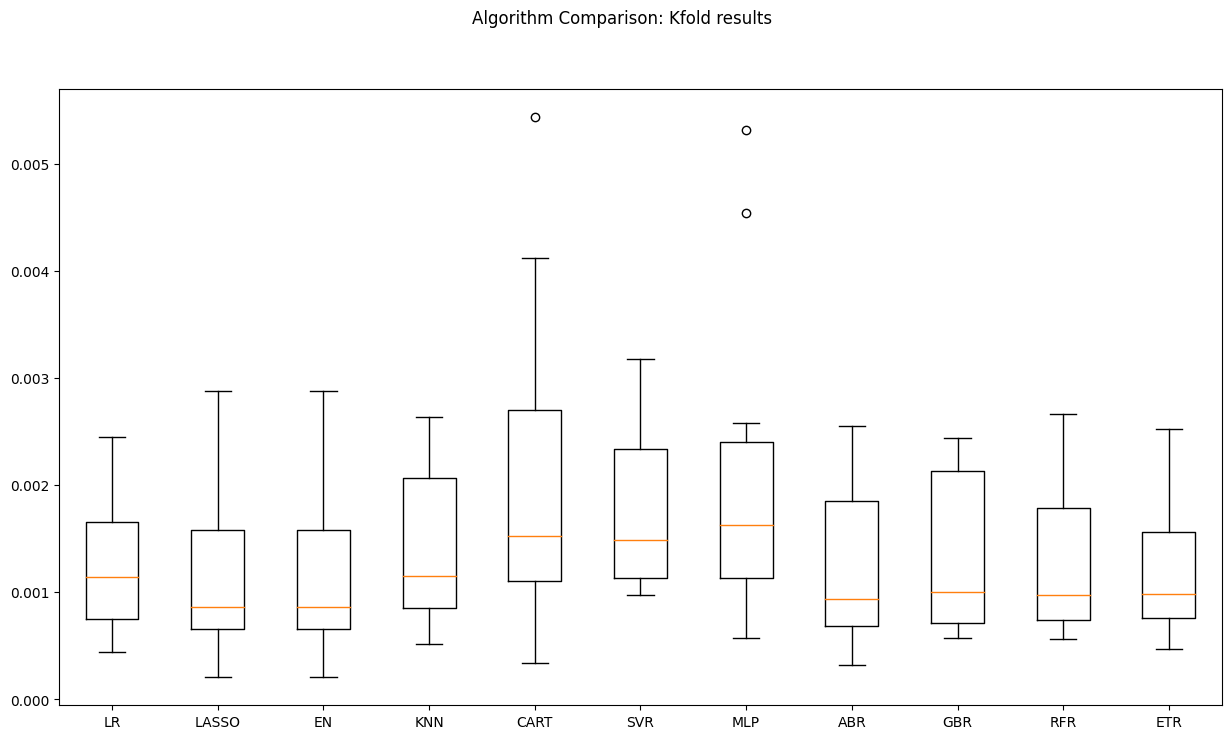

In [21]:
#10-fold cv驗證視覺化

fig = pyplot.figure()

#標題
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)

#kfold_results中數據畫合狀圖
pyplot.boxplot(kfold_results)

#label名稱
ax.set_xticklabels(names)

#圖片尺寸
fig.set_size_inches(15,8)
pyplot.show()

結果顯示線性回歸(LR)、LASSO、彈性網路(EN)表現最好，代表因變數與自變數線性關係強

## 訓練、測試資料驗證視覺化

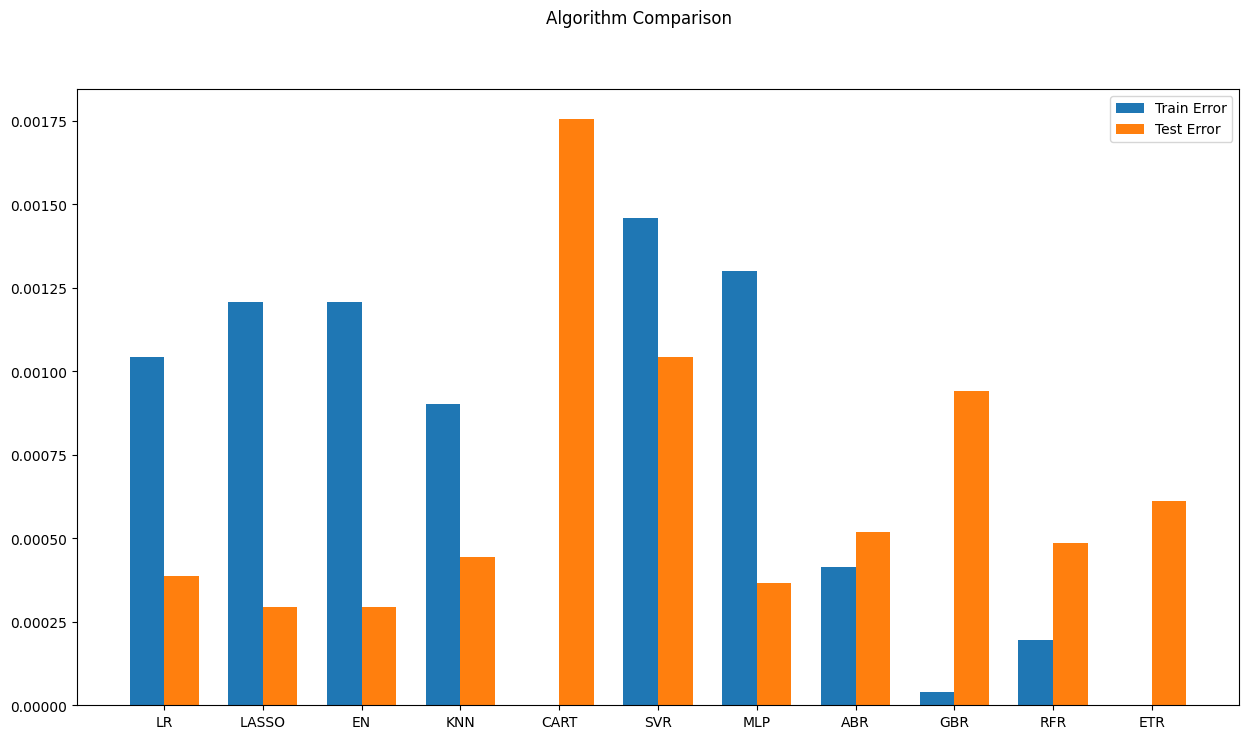

In [22]:
#訓練、測試資料驗證視覺化

fig=pyplot.figure()

#長條圖中心點(訓練長條圖與測試長條圖中間)位置
ind=np.arange(len(names))

#每個演算法(訓練加測試結果)長條圖寬度
width=0.35

#標題
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot()

#畫訓練結果長條圖，參數為(位置、數據、width=寬度,label=圖標)
pyplot.bar(ind-width/2,train_results,width=width,label='Train Error')

#畫測試結果長條圖，參數為(位置、數據、width=寬度,label=圖標)
pyplot.bar(ind+width/2,test_results,width=width,label='Test Error')

#圖片尺寸
fig.set_size_inches(15,8)

#圖標顯示
pyplot.legend()

#設置x軸 label
ax.set_xticks(ind)

#x軸 label名稱
ax.set_xticklabels(names)
pyplot.show()

LR、LASSO、EN:因變數與自變數線性關係強，線性模型績效較好\
CART、ETR:overfitting\
ABR、GBR:低偏差但變異數高\
MLP:測試及訓練誤差都較高，可能是超參數不恰當或是訓練不足

# ARIMA模型

## ARIMA模型訓練/測試資料

In [23]:
#ARIMA模型訓練/測試資料

#ARIMA訓練資料，ARIMA維時間序列模型，不需再把MSFT的落後變數當自變數，只需使用其他變數當外部因素
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]

#ARIMA測試資料，ARIMA維時間序列模型，不需再把MSFT的落後變數當自變數，只需使用其他變數當外部因素
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

## 載入ARIMA模型

In [24]:
#ARIMA模型

#endog:訓練數據  ; exog:衍生變量 : order:[自回歸部分的落後階數、一皆差分次數、移動平均部分的階數 ]
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

## 驗證ARIMA模型

In [25]:

#訓練數據MSE，model_fit.fittedvalues:訓練資料預測結果
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)

#exog:切換為測試資料的衍生變量，start與end切到測試資料區間(te_len-1是測試資料最後一筆的index，tr_len -1是訓練資料最一筆的index)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]

#測試數據MSE
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.00036800030150303397

## 所有模型驗證比較

In [26]:
#ARIMA與監督式學習綜合比較

#ARIMA加入比較
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)

names.append("ARIMA")
#names.append("LSTM")

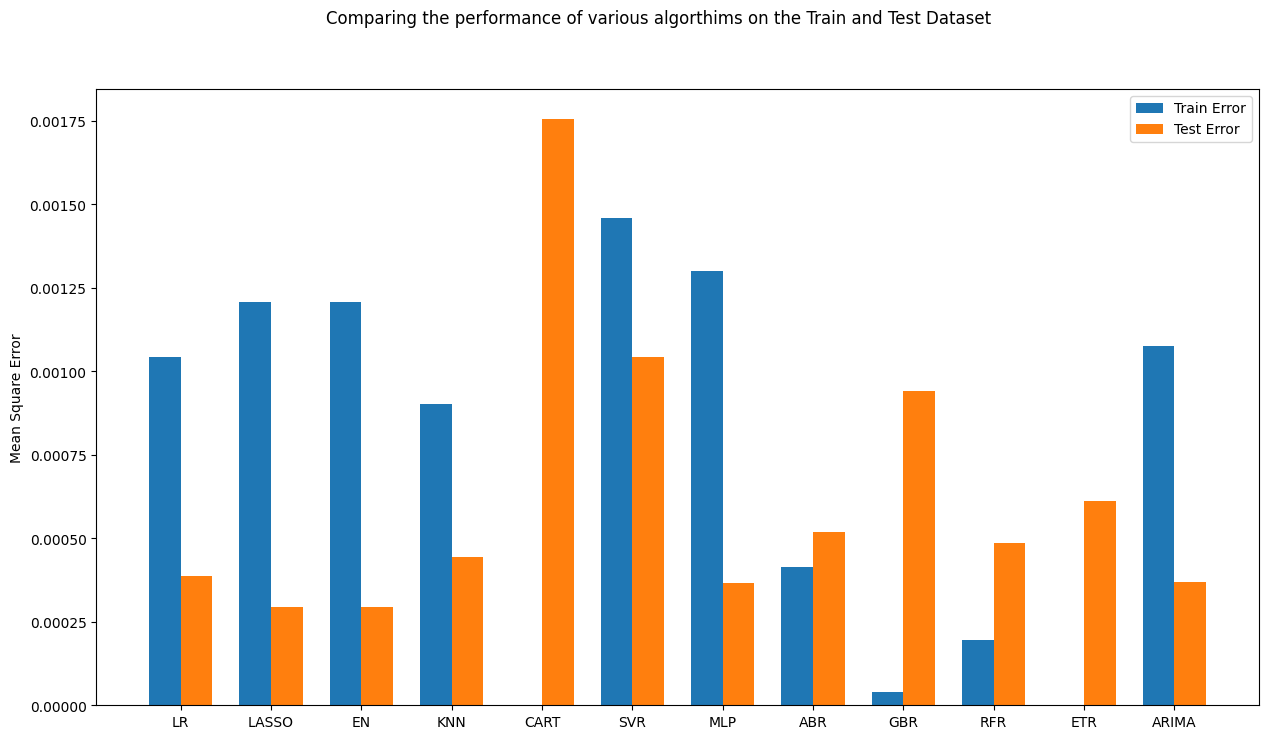

In [27]:
#ARIMA與監督式學習綜合比較圖

# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

## 挑選ARIMA做模型調教

In [28]:
#挑選ARIMA做模型調教


def evaluate_arima_model(arima_order):
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit=modelARIMA.fit()
    error=mean_squared_error(Y_train,model_fit.fittedvalues)
    return error

#p:自回歸部分的落後階數 ; d:一皆差分次數 ; q:移動平均部分的階數 
def evaluate_models(p_values, d_values, q_values):
    best_score=float('inf')
    best_cfg=None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                mse = evaluate_arima_model(order)
                try:
                    
                    if  mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
                
    
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)  
    

ARIMA(0, 0, 0) MSE=0.0010774
ARIMA(0, 0, 1) MSE=0.0010773
ARIMA(0, 1, 0) MSE=0.0019512
ARIMA(0, 1, 1) MSE=0.0011407
ARIMA(1, 0, 0) MSE=0.0010773
ARIMA(1, 0, 1) MSE=0.0010772
ARIMA(1, 1, 0) MSE=0.0015522
ARIMA(1, 1, 1) MSE=0.0011561
ARIMA(2, 0, 0) MSE=0.0010753
ARIMA(2, 0, 1) MSE=0.0010753
ARIMA(2, 1, 0) MSE=0.0014188
ARIMA(2, 1, 1) MSE=0.0011647
Best ARIMA(2, 0, 0) MSE=0.0010753


In [29]:
#挑選模型調教最好的order[1, 0, 1]訓練模型並驗證測試結果

modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

predicted_tuned = model_fit_tuned.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA_tuned = mean_squared_error(Y_test,predicted_tuned)
error_Test_ARIMA_tuned

0.00036859577840239445

結果0.00034371129058170374確實小於剛剛的0.0003553213334564797